<h1>Predicting Future Quarterback Performance</h1>
This notebook will analyze a dataset of quarterback statistics from <b>2014 - 2016</b> and train a linear regression model to predict their <b>passer rating</b>.
By using these predictions, coaches can get an estimate of which quarterbacks are likely to consistently perform well, helping them make informed trade decisions.

In [157]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt


In [158]:
qb_df = pd.read_csv('Game_Logs_Quarterback.csv')
qb_df = qb_df[(qb_df['Year'] >= 2014) & (qb_df['Year'] <= 2016)]
qb_df

,Player Id,Name,Position,Year,Season,Week,Game Date,Home or Away,Opponent,Outcome,...,Ints,Sacks,Sacked Yards Lost,Passer Rating,Rushing Attempts,Rushing Yards,Yards Per Carry,Rushing TDs,Fumbles,Fumbles Lost
30,tomsavage/2543640,"Savage, Tom",QB,2016,Preseason,1,08/14,Away,SF,W,...,0,2,17,107.6,--,--,--,--,--,--
31,tomsavage/2543640,"Savage, Tom",QB,2016,Preseason,2,08/20,Home,NO,W,...,0,2,26,76.7,1,1,1.0,0,1,1
32,tomsavage/2543640,"Savage, Tom",QB,2016,Preseason,3,08/28,Home,ARI,W,...,0,1,8,91.1,--,--,--,--,--,--
33,tomsavage/2543640,"Savage, Tom",QB,2016,Preseason,4,09/01,Away,DAL,W,...,0,0,0,103.7,1,5,5.0,0,--,--
34,tomsavage/2543640,"Savage, Tom",QB,2016,Regular Season,1,09/11,Home,CHI,W,...,--,--,--,0.0,--,--,--,--,--,--
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40112,brockosweiler/2533436,"Osweiler, Brock",QB,2014,Regular Season,17,12/28,Home,OAK,W,...,0,0,0,158.3,1,-1,-1.0,0,--,--
40113,brockosweiler/2533436,"Osweiler, Brock",QB,2014,Postseason,19,01/11,Home,IND,L,...,--,--,--,0.0,--,--,--,--,--,--
40158,mattscott/2539647,"Scott, Matt",NaN,2014,Preseason,1,08/07,Away,KC,L,...,0,1,6,119.7,6,68,11.3,0,--,--
40159,mattscott/2539647,"Scott, Matt",NaN,2014,Preseason,2,08/16,Home,NYJ,L,...,1,4,26,25.9,2,6,3.0,0,2,1



<h1>Exploring and Visualizing the Data</h1>

First, we'll identify what <b>data preprocessing</b> needs to be applied to our data before we start training our linear model. We can start by looking at the how many data samples we have and how many features we have along with the datatypes.


In [159]:
print(qb_df.info())
print(f"The quarterback dataset shape is: {qb_df.shape}")

<class 'pandas.core.frame.DataFrame'>
Index: 4689 entries, 30 to 40160
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Player Id                  4689 non-null   object 
 1   Name                       4689 non-null   object 
 2   Position                   4304 non-null   object 
 3   Year                       4689 non-null   int64  
 4   Season                     4689 non-null   object 
 5   Week                       4689 non-null   int64  
 6   Game Date                  4689 non-null   object 
 7   Home or Away               4689 non-null   object 
 8   Opponent                   4689 non-null   object 
 9   Outcome                    4689 non-null   object 
 10  Score                      4689 non-null   object 
 11  Games Played               4689 non-null   int64  
 12  Games Started              4689 non-null   object 
 13  Passes Completed           4689 non-null   object 


We have 4689 datasamples and 29 features in our dataset. 

There are many features in our dataset that have a datatype of `object`. Some of the values in these columns have numerical values while some have a '--' to indicate no stats were recorded for that game.

The first thing we can do is simplify our dataframe by removing unnecessary columns like Player ID, Name, Position, etc.

In [160]:
drop_list = ['Player Id', 'Name', 'Position', 'Score', 'Week', 'Game Date', 'Opponent']
qb_copy = qb_df.drop(drop_list, axis=1).copy()
qb_copy

,Year,Season,Home or Away,Outcome,Games Played,Games Started,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards,...,Ints,Sacks,Sacked Yards Lost,Passer Rating,Rushing Attempts,Rushing Yards,Yards Per Carry,Rushing TDs,Fumbles,Fumbles Lost
30,2016,Preseason,Away,W,1,0,14,24,58.3,168,...,0,2,17,107.6,--,--,--,--,--,--
31,2016,Preseason,Home,W,1,0,7,12,58.3,75,...,0,2,26,76.7,1,1,1.0,0,1,1
32,2016,Preseason,Home,W,1,0,4,11,36.4,75,...,0,1,8,91.1,--,--,--,--,--,--
33,2016,Preseason,Away,W,1,1,12,18,66.7,119,...,0,0,0,103.7,1,5,5.0,0,--,--
34,2016,Regular Season,Home,W,0,0,--,--,--,--,...,--,--,--,0.0,--,--,--,--,--,--
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40112,2014,Regular Season,Home,W,1,0,2,2,100.0,39,...,0,0,0,158.3,1,-1,-1.0,0,--,--
40113,2014,Postseason,Home,L,0,0,--,--,--,--,...,--,--,--,0.0,--,--,--,--,--,--
40158,2014,Preseason,Away,L,1,0,7,11,63.6,66,...,0,1,6,119.7,6,68,11.3,0,--,--
40159,2014,Preseason,Home,L,1,0,8,22,36.4,54,...,1,4,26,25.9,2,6,3.0,0,2,1


Next we'll replace all '--' values with 0 and double check to make sure our dataset doesn't have any null values using pandas' `isnull()` and numpy's `any()` methods.

In [161]:
mask = qb_copy == '--'
missing_vals_cols = qb_copy.columns[mask.any()]
print(f'Columns with \'--\' values: \n{list(missing_vals_cols)}')

#Replacing '--' with 0
qb_copy = qb_copy.applymap(lambda x: 0 if x == '--' else x)
display(qb_copy)

qb_isnull = qb_copy.isnull()
qb_has_null_values = np.any(qb_isnull)
qb_isnull
print(f'\nDataset has null values? {qb_has_null_values}.')

Columns with '--' values: 
['Passes Completed', 'Passes Attempted', 'Completion Percentage', 'Passing Yards', 'Passing Yards Per Attempt', 'TD Passes', 'Ints', 'Sacks', 'Sacked Yards Lost', 'Rushing Attempts', 'Rushing Yards', 'Yards Per Carry', 'Rushing TDs', 'Fumbles', 'Fumbles Lost']


,Year,Season,Home or Away,Outcome,Games Played,Games Started,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards,...,Ints,Sacks,Sacked Yards Lost,Passer Rating,Rushing Attempts,Rushing Yards,Yards Per Carry,Rushing TDs,Fumbles,Fumbles Lost
30,2016,Preseason,Away,W,1,0,14,24,58.3,168,...,0,2,17,107.6,0,0,0,0,0,0
31,2016,Preseason,Home,W,1,0,7,12,58.3,75,...,0,2,26,76.7,1,1,1.0,0,1,1
32,2016,Preseason,Home,W,1,0,4,11,36.4,75,...,0,1,8,91.1,0,0,0,0,0,0
33,2016,Preseason,Away,W,1,1,12,18,66.7,119,...,0,0,0,103.7,1,5,5.0,0,0,0
34,2016,Regular Season,Home,W,0,0,0,0,0,0,...,0,0,0,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40112,2014,Regular Season,Home,W,1,0,2,2,100.0,39,...,0,0,0,158.3,1,-1,-1.0,0,0,0
40113,2014,Postseason,Home,L,0,0,0,0,0,0,...,0,0,0,0.0,0,0,0,0,0,0
40158,2014,Preseason,Away,L,1,0,7,11,63.6,66,...,0,1,6,119.7,6,68,11.3,0,0,0
40159,2014,Preseason,Home,L,1,0,8,22,36.4,54,...,1,4,26,25.9,2,6,3.0,0,2,1



Dataset has null values? False.


In [162]:
qb_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4689 entries, 30 to 40160
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       4689 non-null   int64  
 1   Season                     4689 non-null   object 
 2   Home or Away               4689 non-null   object 
 3   Outcome                    4689 non-null   object 
 4   Games Played               4689 non-null   int64  
 5   Games Started              4689 non-null   object 
 6   Passes Completed           4689 non-null   object 
 7   Passes Attempted           4689 non-null   object 
 8   Completion Percentage      4689 non-null   object 
 9   Passing Yards              4689 non-null   object 
 10  Passing Yards Per Attempt  4689 non-null   object 
 11  TD Passes                  4689 non-null   object 
 12  Ints                       4689 non-null   object 
 13  Sacks                      4689 non-null   object 


After replacing all missing values with 0, our columns still have the `object` data type. To fix this, we'll change the column datatype using pandas' `to_numeric()` function on our `missing_vals_cols`.

In [163]:
qb_copy[missing_vals_cols] = qb_copy[missing_vals_cols].apply(pd.to_numeric, errors='coerce').copy()
qb_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4689 entries, 30 to 40160
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       4689 non-null   int64  
 1   Season                     4689 non-null   object 
 2   Home or Away               4689 non-null   object 
 3   Outcome                    4689 non-null   object 
 4   Games Played               4689 non-null   int64  
 5   Games Started              4689 non-null   object 
 6   Passes Completed           4689 non-null   int64  
 7   Passes Attempted           4689 non-null   int64  
 8   Completion Percentage      4689 non-null   float64
 9   Passing Yards              4689 non-null   int64  
 10  Passing Yards Per Attempt  4689 non-null   float64
 11  TD Passes                  4689 non-null   int64  
 12  Ints                       4689 non-null   int64  
 13  Sacks                      4689 non-null   int64  


It looks like we still have a few features with the `object` datatype. Lets get a closer look at `Games Started` to determine whether we should change this to a numerical feature since `Games Played` has a numeric data type.

(array([2821.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1868.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

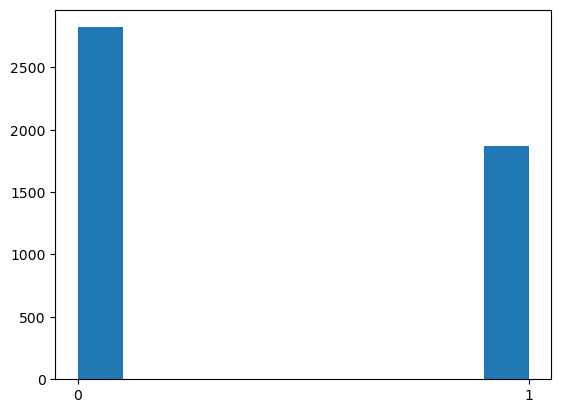

In [164]:
games_started_df = qb_copy['Games Started']
plt.hist(games_started_df)

Looks like there are only 2 values for this feature, 0 and 1, where 0 means false and 1 means true. We can go ahead and convert this feature to a numerical datatype. 

In [165]:
qb_copy['Games Started'] = qb_copy['Games Started'].apply(pd.to_numeric, errors='coerce').copy()
qb_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4689 entries, 30 to 40160
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year                       4689 non-null   int64  
 1   Season                     4689 non-null   object 
 2   Home or Away               4689 non-null   object 
 3   Outcome                    4689 non-null   object 
 4   Games Played               4689 non-null   int64  
 5   Games Started              4689 non-null   int64  
 6   Passes Completed           4689 non-null   int64  
 7   Passes Attempted           4689 non-null   int64  
 8   Completion Percentage      4689 non-null   float64
 9   Passing Yards              4689 non-null   int64  
 10  Passing Yards Per Attempt  4689 non-null   float64
 11  TD Passes                  4689 non-null   int64  
 12  Ints                       4689 non-null   int64  
 13  Sacks                      4689 non-null   int64  


 We will need to `One Hot Encode` the categorical features `Season`, `Home or Away`, and `Outcome` into numerical values to feed into our linear regression model.

<h4>Data Preprocessing To Do List</h4>

<li>One Hot Encode categorical features: <i>Season, Home or Away, Outcome</i></li>



Now that our numeric features have the right datatypes, let's start to explore our data. We'll start by looking at the statistics.

In [166]:
qb_copy.describe()

,Year,Games Played,Games Started,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards,Passing Yards Per Attempt,TD Passes,Ints,Sacks,Sacked Yards Lost,Passer Rating,Rushing Attempts,Rushing Yards,Yards Per Carry,Rushing TDs,Fumbles,Fumbles Lost
count,4689.000000,4689.000000,4689.000000,4689.000000,4689.000000,4689.000000,4689.000000,4689.000000,4689.000000,4689.000000,4689.000000,4689.000000,4689.000000,4689.000000,4689.000000,4689.000000,4689.000000,4689.000000,4689.000000
mean,2015.027938,0.574749,0.398379,8.483472,13.573470,33.316805,96.740456,3.840115,0.595010,0.317978,0.875453,5.653871,46.901514,1.210279,4.919812,1.499190,0.043506,0.206014,0.080614
std,0.815190,0.494434,0.489617,10.388722,16.325409,33.057225,120.172609,4.258327,1.001697,0.675462,1.430803,9.964476,49.087661,2.024839,12.063769,3.206673,0.213218,0.518635,0.296282
min,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,-1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-12.000000,-6.000000,0.000000,0.000000,0.000000
25%,2014.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,1.000000,0.000000,2.000000,4.000000,41.700000,19.000000,3.600000,0.000000,0.000000,0.000000,0.000000,39.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2016.000000,1.000000,1.000000,17.000000,28.000000,63.600000,196.000000,7.100000,1.000000,0.000000,1.000000,8.000000,89.600000,2.000000,4.000000,2.000000,0.000000,0.000000,0.000000
max,2016.000000,1.000000,1.000000,43.000000,65.000000,100.000000,522.000000,63.000000,7.000000,6.000000,10.000000,91.000000,158.300000,17.000000,151.000000,28.000000,2.000000,4.000000,3.000000


It seems like some of our features are operating on different scales. Since we are using linear regression we'll want to standardize our features so that our model will not add heavier weights to features with large values like `Passing Yards`, which will affect model performance, and so that regularzation treats all features fairly.  

<h4>Data Preprocessing To Do List</h4>

<li>One Hot Encode categorical features: <i>Season, Home or Away, Outcome</i></li>
<li>Scale numerical features using <i>Standardization</i></li>


Let's take a closer look at our target `Passer Rating`. 

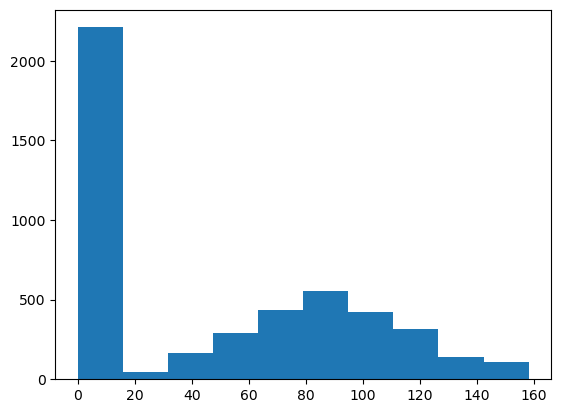

Passer Rating
0.0      2185
39.6       55
158.3      26
118.8      20
56.2       15
         ... 
109.2       1
150.6       1
106.7       1
142.9       1
10.8        1
Name: count, Length: 957, dtype: int64

In [167]:
passer_rating_df = qb_copy['Passer Rating']
plt.hist(passer_rating_df)
plt.show()

passer_rating_vc = passer_rating_df.value_counts()
passer_rating_vc

It looks like a majority of our values are at 0, this indicates that our data is  skewed. This is a problem for a linear regression model because it assumes that the error between predictions and ground truth labels are normally distributed. We'll want to normally distribute our `Passer Rating` target using logarithmic transformation, where taking the <b><i>log<i></b> of our skewed distributions help push it towards being more normally distributed. 

<h4>Data Preprocessing To Do List</h4>

<li>One Hot Encode categorical features: <i>Season, Home or Away, Outcome, Games Started</i></li>
<li>Scale numerical features using <i>Standardization</i></li>
<li>Log Transform our Target <b>Passer Rating</b></li>



Now we want to see if there any any correlations between our features and our target `Passer Rating`. Lets take a look at our data and see if we can find any trends. 

C:\Users\gclou\AppData\Local\Temp\ipykernel_25960\3729053126.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(9, 3, idx+1)


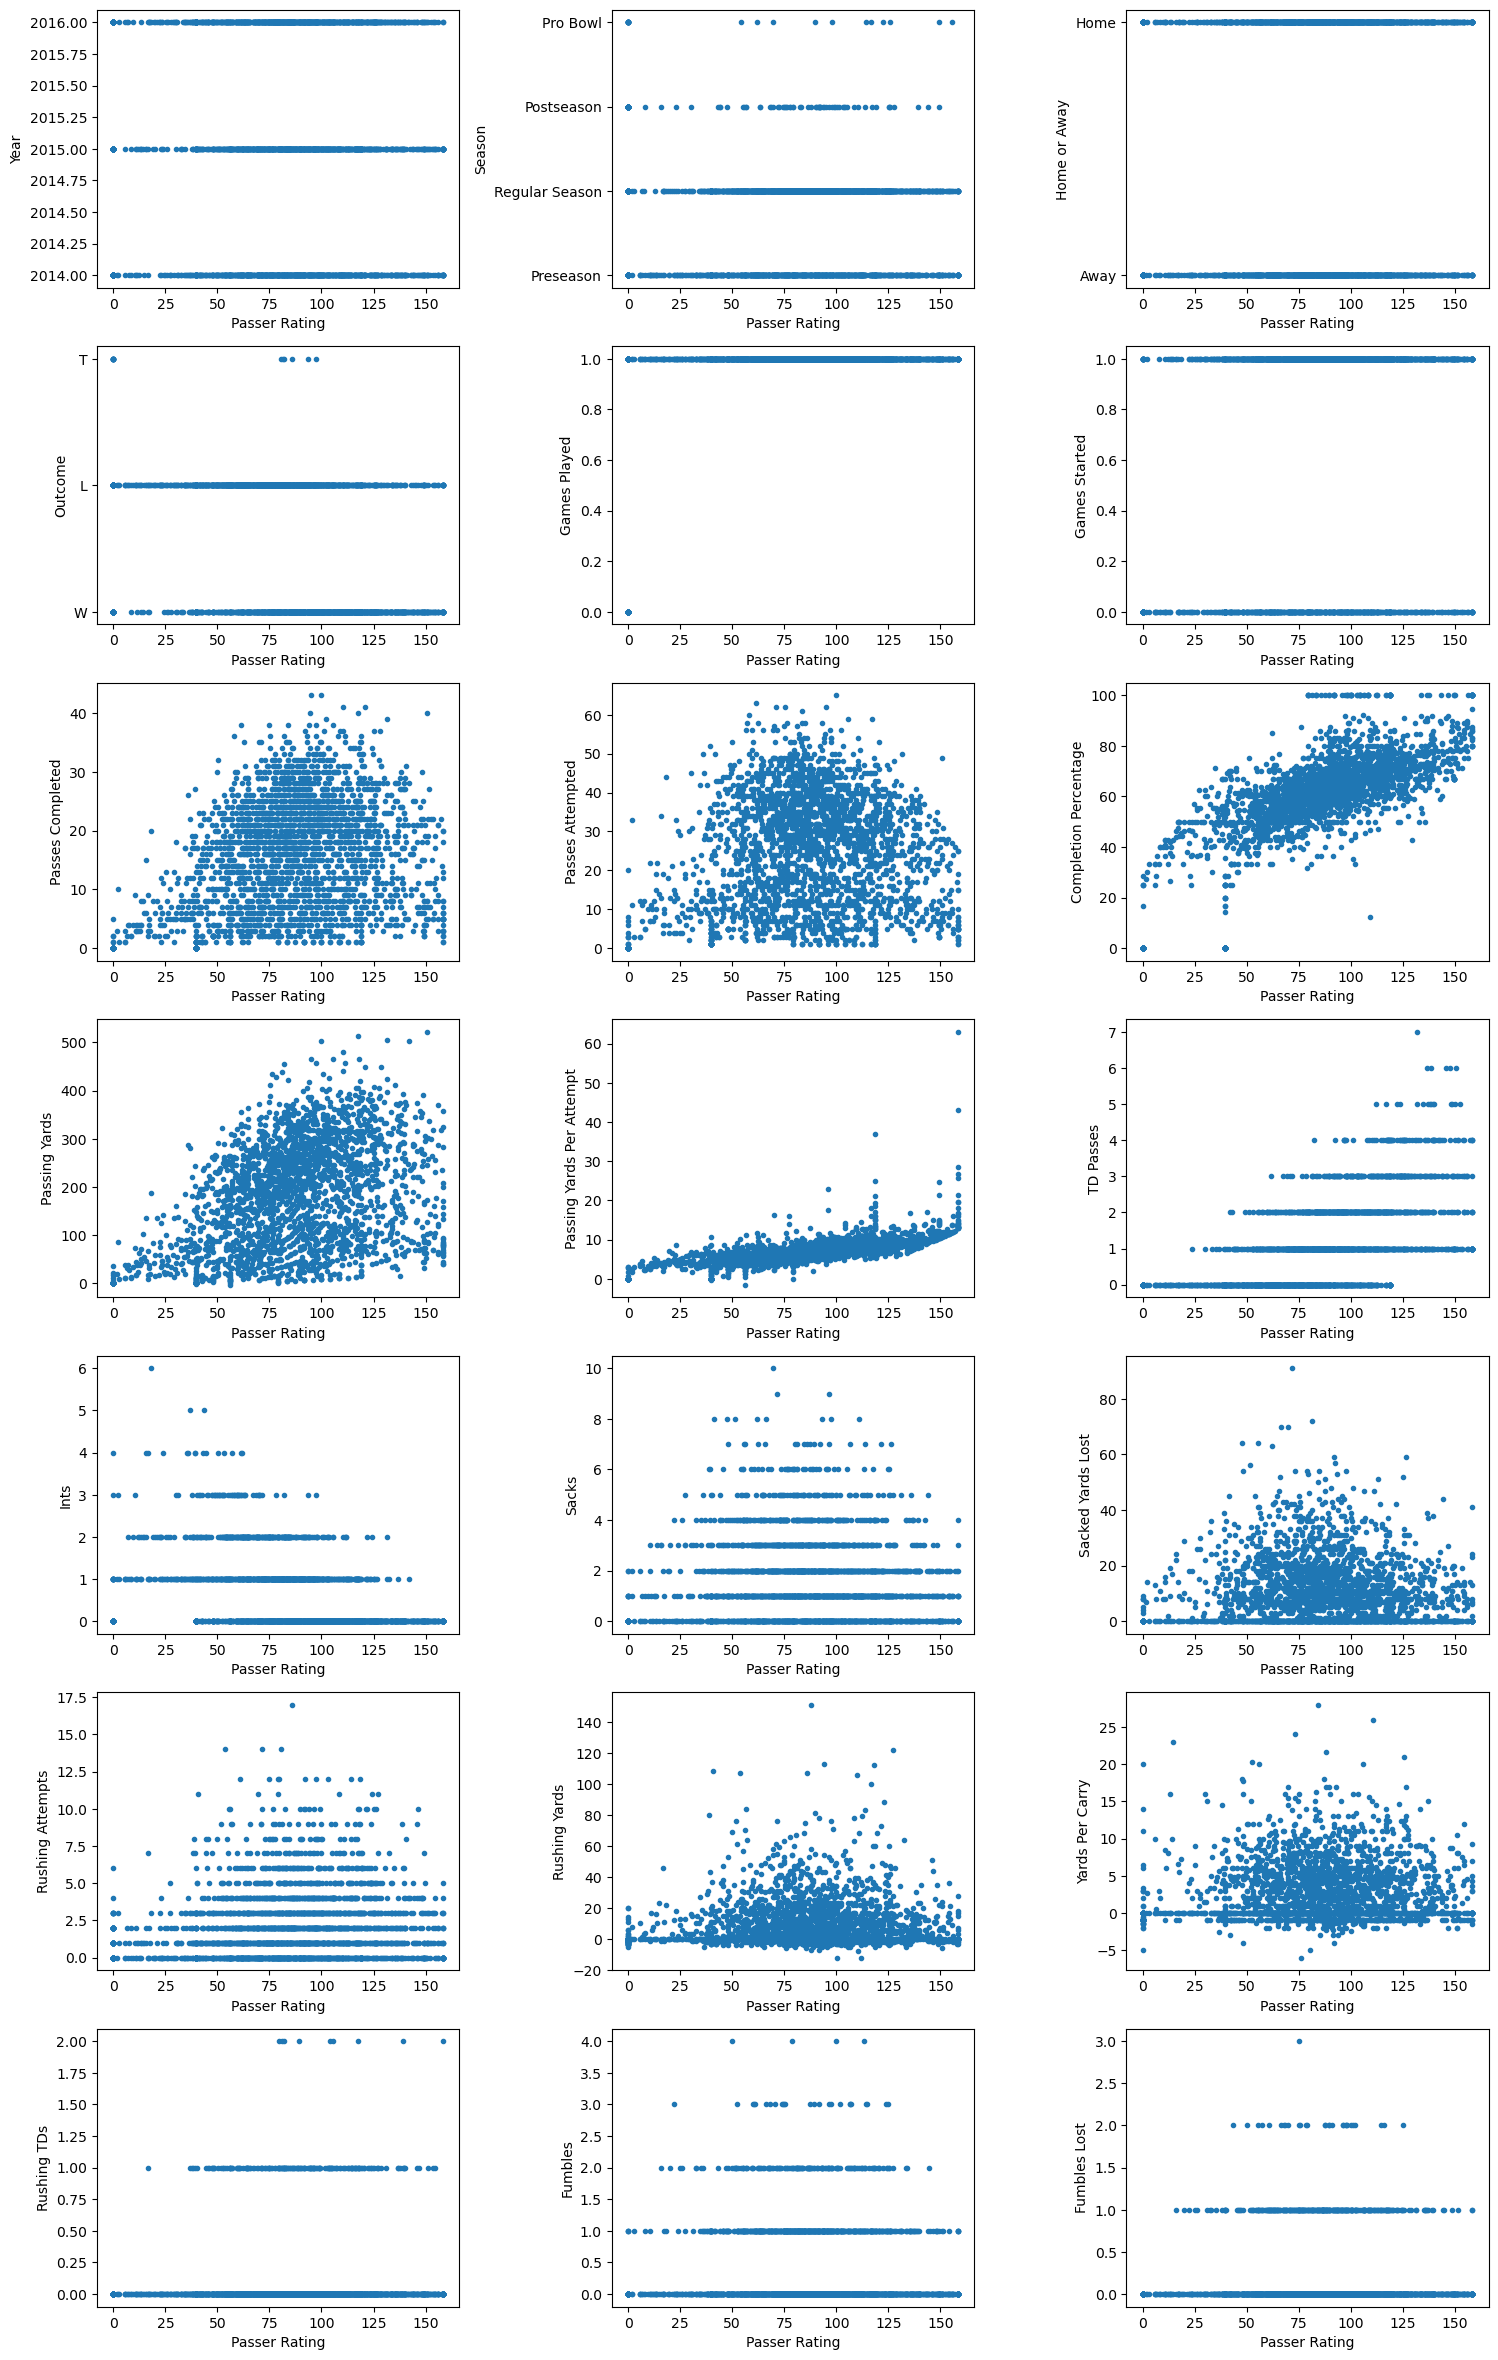

In [168]:
X = qb_copy.drop(['Passer Rating'], axis=1)
y = qb_copy['Passer Rating']

fig, _ = plt.subplots(figsize=(15, 30))
#Loop over feature column names and get index position of each column
for idx, column_name in enumerate(X.columns.values):
    plt.subplot(9, 3, idx+1)
    plt.plot(y, X[column_name], '.')
    plt.ylabel(column_name)
    plt.xlabel('Passer Rating')
    
fig.tight_layout()

In [169]:
cat_cols = ['Season', 'Home or Away', 'Outcome']
qb_numerical_cols = qb_copy.drop(cat_cols, axis=1)
qb_corr = qb_numerical_cols.corr()
qb_corr['Passer Rating']

Year                        -0.025412
Games Played                 0.821947
Games Started                0.705637
Passes Completed             0.742007
Passes Attempted             0.702369
Completion Percentage        0.941715
Passing Yards                0.770264
Passing Yards Per Attempt    0.914913
TD Passes                    0.713085
Ints                         0.202635
Sacks                        0.482870
Sacked Yards Lost            0.446614
Passer Rating                1.000000
Rushing Attempts             0.513247
Rushing Yards                0.346685
Yards Per Carry              0.385050
Rushing TDs                  0.185098
Fumbles                      0.314471
Fumbles Lost                 0.218322
Name: Passer Rating, dtype: float64

Based on our scatter plot and correlation matrix, we observe strong correlations between `Passer Rating` and the following features: `Games Played`, `Games Started`, `Passes Completed`, `Passes Attempted`, `Completion Percentage`, `Passing Yards`, `Passing Yards Per Attempt`, and `TD Passes`. To improve model efficiency and reduce noise, we will use these features as predictors for our linear regression model.

In [170]:
predictors = ['Games Played', 'Games Started', 'Passes Completed', 'Passes Attempted', 'Completion Percentage', 'Passing Yards', 'Passing Yards Per Attempt', 'TD Passes']
target = ['Passer Rating']
qb_copy = qb_copy[cat_cols + predictors + target]
qb_copy

,Season,Home or Away,Outcome,Games Played,Games Started,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards,Passing Yards Per Attempt,TD Passes,Passer Rating
30,Preseason,Away,W,1,0,14,24,58.3,168,7.0,2,107.6
31,Preseason,Home,W,1,0,7,12,58.3,75,6.3,0,76.7
32,Preseason,Home,W,1,0,4,11,36.4,75,6.8,1,91.1
33,Preseason,Away,W,1,1,12,18,66.7,119,6.6,1,103.7
34,Regular Season,Home,W,0,0,0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
40112,Regular Season,Home,W,1,0,2,2,100.0,39,19.5,1,158.3
40113,Postseason,Home,L,0,0,0,0,0.0,0,0.0,0,0.0
40158,Preseason,Away,L,1,0,7,11,63.6,66,6.0,2,119.7
40159,Preseason,Home,L,1,0,8,22,36.4,54,2.5,0,25.9


<h2>Data Preprocessing</h2>
Now we can finally clean and split our data prepping it for our linear regression model. Recall the preprocessing to do list we created while exploring our data:

<h4>To Do List</h4>

<li>One Hot Encode categorical features: <i>Season, Home or Away, Outcome</i></li>
<li>Scale numerical features using <i>Standardization</i></li>
<li>Log Transform our Target <i>Passer Rating</i></li>



<h5>Data Cleaning Classes</h5>

We'll be using sklearn's `ColumnTransformer` to create a data preprocessing pipeline that will transform our data as defined by our stages passed through the constructor in sequential order. The output will usually return a numpy array but our wrapper class `DataFrameCOlumnTransformer` will convert this to a DataFrame.

In [171]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from typing import List, Tuple, Callable

In [172]:
class DataFrameColumnTransformer(TransformerMixin):
    def __init__(self, 
                 stages: List[Tuple]):
        
        self.col_trans = ColumnTransformer(stages)

    def fit(self, 
            X: pd.DataFrame):
        
        #Runs ColumnTransformer.fit() method
        self.col_trans.fit(X)
        return self

    def transform(self, 
                  X: pd.DataFrame) -> pd.DataFrame:
        
        #Runs ColumnTransformer.transform() method
        output_arr = self.col_trans.transform(X)

        return self.to_dataframe(output_arr)

    def to_dataframe(self, 
                     arr: np.ndarray) -> pd.DataFrame:
        
        #Convert our output from ColumnTransformer.transform() into a DataFrame
        feature_names = self.col_trans.get_feature_names_out()

        #Remove the __ that ColumnTransformer adds to our feature name when calling .get_feature_names_out()
        for i, name in enumerate(feature_names):
            if '__' in name:
                feature_names[i] = name.split('__', 1)[-1]

        #Create pandas DataFrame
        df = pd.DataFrame(arr, columns=feature_names)
        
        return df
        

<h5>1. One Hot Encoding</h5>

In [173]:
"""
Transforms our categorical features into numerical features.
"""
class OneHotEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        
        #Tracking categorical to numerical feature names
        self.feature_names = None
        pass

    def fit(self, 
            X: pd.DataFrame, 
            y: pd.DataFrame = None):
        
        #We don't need to return any variables
        return self

    def transform(self, 
                  X: pd.DataFrame, 
                  y: pd.DataFrame = None) -> pd.DataFrame:
        
        one_hot = pd.get_dummies(X)
        self.feature_names = one_hot.columns

        return one_hot
   
    #Returns a list of new names for our categorical features
    def get_feature_names_out(self, 
                              names=None) -> List[str]:
        return list(self.feature_names)

<h5>2. Log Transformation</h5>

In [174]:
class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        #Tracking numerical feature names
        self.feature_names = None
        pass

    def fit(self, X: pd.DataFrame, y: pd.DataFrame = None):
        return self

    def transform(self, X: pd.DataFrame, y: pd.DataFrame = None) -> pd.DataFrame:
        self.feature_names = X.columns
        return np.log1p(X)

    def get_feature_names_out(self, names=None) -> List[str]:
        return list(self.feature_names)

<h5>Before Pipeline</h5>

We'll be defining a `before_pipeline` function to apply `OneHotEncoding` and `LogTransformer` to our quaterback dataset.

In [329]:
def before_pipeline(qb_copy):
    passthrough_cols = qb_copy.drop(cat_cols + ['Passer Rating'], axis=1).columns
    passthrough_cols
    stages = [
        ('pass', 'passthrough', passthrough_cols),
        ('one_hot', OneHotEncoding(), cat_cols),
        ('log', LogTransformer(), ['Passer Rating'])
    ]

    before_pipe = DataFrameColumnTransformer(stages)

    cleaner_df = before_pipe.fit_transform(qb_copy)

    return cleaner_df

After running the `before_pipeline` function, we have successfully added new categorical features by applying `OneHotEncoding`. Additionally, the `Passer Rating` histogram now appears more normally distributed after applying `LogTransform`.

,Games Played,Games Started,Passes Completed,Passes Attempted,Completion Percentage,Passing Yards,Passing Yards Per Attempt,TD Passes,Season_Postseason,Season_Preseason,Season_Pro Bowl,Season_Regular Season,Home or Away_Away,Home or Away_Home,Outcome_L,Outcome_T,Outcome_W,Passer Rating
0,1.0,0.0,14.0,24.0,58.3,168.0,7.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.687671
1,1.0,0.0,7.0,12.0,58.3,75.0,6.3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.352855
2,1.0,0.0,4.0,11.0,36.4,75.0,6.8,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.522875
3,1.0,1.0,12.0,18.0,66.7,119.0,6.6,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.651099
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4684,1.0,0.0,2.0,2.0,100.0,39.0,19.5,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,5.070789
4685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000
4686,1.0,0.0,7.0,11.0,63.6,66.0,6.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4.793308
4687,1.0,0.0,8.0,22.0,36.4,54.0,2.5,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3.292126


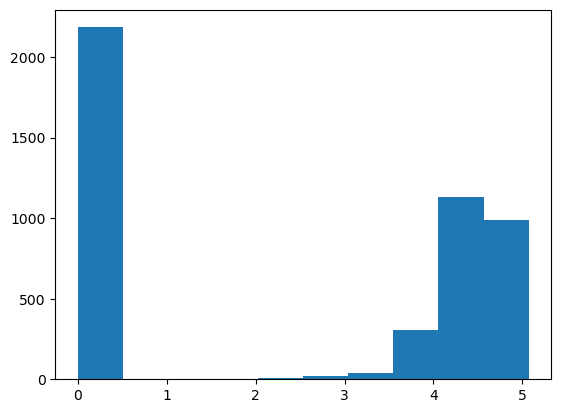

In [330]:
cleaner_df = before_pipeline(qb_copy)
display(cleaner_df)
plt.hist(cleaner_df['Passer Rating'])
plt.show()

<h5>3. Scale numerical features using <i>Standardization</i></h5>
Let's define an `AddBias` class for adding a bias to our train, validation, and test splits.

In [411]:
class AddBias(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None

    def fit(self, 
            X: pd.DataFrame, 
            y: pd.DataFrame = None):
        return self

    #Adding bias term
    def transform(self,
                  X: pd.DataFrame,
                  y: pd.DataFrame = None) -> pd.DataFrame:
        X = X.copy()
        X.insert(0, 'Bias', 1)

        self.feature_names = X.columns
        return X

    def get_feature_names_out(self,
                              names=None) -> List[str]:
        return list(self.feature_names)

Lets define a `Standardization` class for scaling our numerical features.

In [412]:
class Standardization(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None
        pass

    def fit(self, 
            X: pd.DataFrame, 
            y: pd.DataFrame = None) -> pd.DataFrame:
        
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        return self
        
    def transform(self,
                  X: pd.DataFrame,
                 y: pd.DataFrame = None) -> pd.DataFrame:
        
        std_of_X = (X - self.mean) / self.std
        self.feature_names = X.columns
        return std_of_X

    def get_feature_names_out(self, names=None) -> pd.Series:
        return self.feature_names

Finally, lets define a `feature_label_split()`

In [438]:
def feature_label_split(cleaner_df):
    X = cleaner_df.drop('Passer Rating', axis=1)
    y = cleaner_df['Passer Rating'].copy()

    return X, y

Now we're ready to create an `after_pipeline()` function that will standardize our data and add a bias to our training, validation, and test splits. 

In [447]:
def after_pipeline(X_train, X_test):
    stages = [
        ('scaler', Standardization()),
        ('bias', AddBias())
    ]

    after_pipe = Pipeline(stages)
    X_train_clean = after_pipe.fit_transform(X_train)
    X_test_clean = after_pipe.transform(X_test)

    

    return X_train_clean, X_test_clean


Let's put it all together into one `Data_Prep` function.

In [458]:
from sklearn.model_selection import train_test_split

def Data_Prep(qb_copy):
    #Apply pre-split cleaning
    cleaner_df = before_pipeline(qb_copy)
    
    #Apply feature label split on our dataset
    X, y = feature_label_split(cleaner_df)
    
    #Apply training and testing set split to X, y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #Apply post-split cleaning
    X_train, X_test = after_pipeline(X_train, X_test)

    #Return as np.ndarrays
    X_train, y_train, X_test, y_test = (X_train.values,
                                        y_train.values,
                                        X_test.values,
                                        y_test.values)

    return X_train, y_train, X_test, y_test, cleaner_df

<h2>Training the Model</h2>
Now we can finally train our linear regression model. Since our dataset has less than 10,000 rows, we will be using `OrdinaryLeastSquares` to compute the best weights for our model.

In [513]:
"""
Directly computes the best weights for our model
"""
class OrdinaryLeastSquares():
    def __init__(self):
        self.w = None
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self.w = np.linalg.pinv(X.T @ X) @ X.T @ y
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        return X @ self.w

"""
Calculates the MSE and RMSE of our linear model. Returns mse, rmse.
"""
def Performance_Measures(y: np.ndarray, preds: np.ndarray):
    err = preds - y
    mse = np.mean(err**2)
    rmse = np.sqrt(mse)
    r_squared = 1 - np.sum((y - preds)**2) / np.sum((y - np.mean(y))**2)
    return mse, rmse, r_squared

"""
Linear model makes predictions on the data that is passed in.
Returns X: np.ndarray, y: np.ndarray, preds: predictions made, ols: Linear model
"""
def Run_Lin_Model(X, y, ols):
    preds = ols.predict(X)
    
    mse, rmse, r_squared = Performance_Measures(y, preds)

    return X, y, preds, mse, rmse, r_squared, ols


def Plot_Predictions(X_train, y_train, X_test, y_test, ols, cleaner_df):
    # Create subplots
    fig = plt.figure(figsize=(10, 5))
    gs = GridSpec(1,1) #1 row 1 column
    ax1 = fig.add_subplot(gs[0,:])

    X_train_df = pd.DataFrame(X_train, columns = cleaner_df.columns)
    X_test_df = pd.DataFrame(X_test, columns = cleaner_df.columns)

    _, _, preds_train, mse_train, rmse_train, r_squared_train, _ = Run_Lin_Model(X_train, y_train, ols)
    _, _, preds_test, mse_test, rmse_test, r_squared_test, _ = Run_Lin_Model(X_test, y_test, ols)
    print(f'Training performance\nMSE:{mse_train} RMSE: {rmse_train} \nR^2: {r_squared_train}\n\nTesting performance\nMSE:{mse_test} RMSE: {rmse_test} \nR^2: {r_squared_test}')
    ax1.plot(X_train_df.index, y_train, '.b', label='Training data')
    ax1.plot(X_test_df.index, y_test, '.g', label='Testing data')
    ax1.plot(X_train_df.index, np.exp(preds_train)-1, 'xm', alpha=0.1, label='Training predictions')
    ax1.plot(X_test_df.index, np.exp(preds_test)-1, 'xr', alpha=0.1, label='Testing predictions')
    ax1.set_title('Training + Testing Predictions')
    ax1.set_xlabel('Quarterback DataSamples')
    ax1.set_ylabel('PasserRating')
    ax1.legend()
    
    
    

    



Training performance
MSE:0.170714419265015 RMSE: 0.4131760148714044 
R^2: 0.9653838408428557

Testing performance
MSE:0.19600174866140524 RMSE: 0.44272084733091716 
R^2: 0.9606960883404968


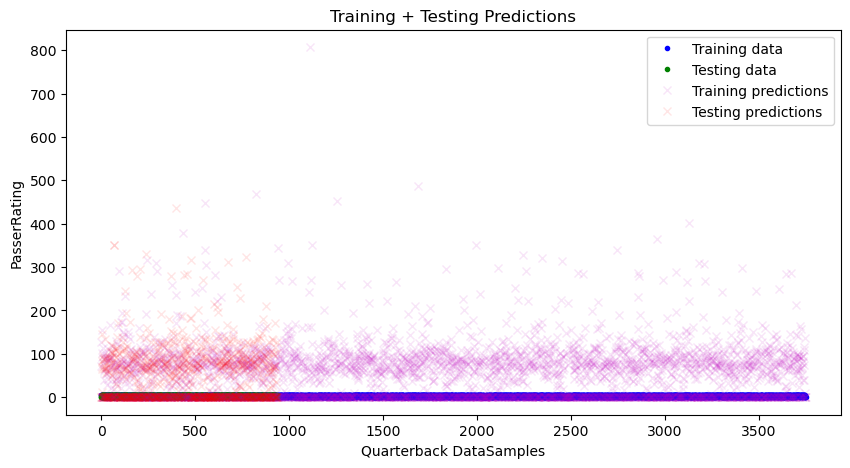

In [514]:
#Split data into train, valid, test splits
X_train, y_train, X_test, y_test, cleaner_df = Data_Prep(qb_copy)

ols = OrdinaryLeastSquares()
ols.fit(X_train, y_train)

Plot_Predictions(X_train, y_train, X_test, y_test, ols, cleaner_df)




<h2>Observations</h2>
The MSE and RMSE values for both training and testing are quite close, suggesting that the model is not overfitting or underfitting significantly.

Training MSE (0.1707) and RMSE (0.4132) are low, which suggests that the model fits the training data well.

Testing MSE (0.1960) and RMSE (0.4427) are slightly higher, indicating that the model is generalizing well to unseen data but may still have room for improvement.

The R² value is high for both training (0.965) and testing (0.961), suggesting that around 96% of the variance in the label `Passer Rating` is explained by the features, both in training and testing.

These results indicate a well-performing model with minimal overfitting, as the training and testing R² values are very close to each other. We could further tune this model through `feature engineering` and `regularzation`